## Import libraries

In [2]:
from PyQt5.QtWidgets import QFileDialog  
import json as js
import numpy as np
import pandas as pd
from pathlib import Path, PureWindowsPath
from scipy import io
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.special import erf
from scipy.constants import elementary_charge, Boltzmann 
from math import pi
from math import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages

import os
import timeit
from bisect import bisect_left, bisect_right
import re
import itertools

import ipywidgets as widgets
from IPython.display import display

In [3]:
import warnings
#warnings.filterwarnings("error")
#warnings.filterwarnings("default")
warnings.filterwarnings("ignore")

# Stefans plotting setup

In [4]:
def figsize(scale):
    fig_width_pt = 432.487                     # Get this from LaTeX using \showthe\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio
    # one plot
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    # splitted plots
    #fig_width = fig_width_pt*inches_per_pt*0.4    # width in inches
    #fig_height = fig_width*0.9 
    fig_size = [fig_width,fig_height]
    return fig_size

# Use Latex Sans-Serif font and set other plot properties
params = {
    'text.usetex': True,
    #'text.usetex': False,
    'text.latex.unicode': True,
    'figure.figsize': figsize(0.8), # default figsize
    'axes.labelsize': 11, # LaTeX default is 10pt font. 11
    'font.size': 11,
    'legend.fontsize': 9, # Make the legend/label fonts a little smaller 9
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'text.latex.preamble': [
        r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
        r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
        r'\usepackage[version=4]{mhchem}',   # i need upright \micro symbols, but you need...
#        r'\usepackage{helvet}',   # if you want to use helvetica
#        r'\usepackage[helvet]{sfmath}' # if you want to use helvetica
        r'\usepackage{lmodern}',
        r'\renewcommand*\familydefault{\sfdefault}' # Only if the base font of the document is to be sans serif
        r'\usepackage{sfmath}'
        r'\newcommand{\dif}{\mathop{}\!\mathrm{d}}' # differential d
        ]
    ,
    'axes.linewidth': 1.0,
    #'lines.linewidth': 1.0,
    #'lines.markersize': 5.0,
    #'lines.markeredgewidth': 0.1,
    #'xtick.major.width': 1.0,
    #'ytick.major.width': 1.0,
    #'xtick.minor.width': 0.8,
    #'ytick.minor.width': 0.8,
    }
mpl.rcParams.update(params)

format_B_legend = '{:1.0f}'
format_D_legend = '{:1.3f}'
format_T_legend = '{:1.2f}'
# Use Latex Sans-Serif font
#plt.rcParams['text.latex.preamble'] = [
#       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
#       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
#       r'\usepackage{helvet}',    # set the normal font here
#       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
#       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
#]
#plt.rc('text', usetex=True)
# Use non-Latex Sans-Serif font
#params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
#plt.rcParams.update(params)

# Live Plotting

### Quick Plotting

#### Search and import file 

In [69]:
%gui qt5
default_path = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity'
filename = PureWindowsPath(default_path)
default_path = Path(filename)
filename = QFileDialog.getOpenFileName(None, 'Import file', str(default_path),"Text files (*.csv *.dat *.txt)")
print(filename[0])
file_import = Path(filename[0])
#quick_data = np.loadtxt(file_import, skiprows=1)
quick_data = pd.read_csv(file_import, sep=r'\t+\s*', engine='python')
quick_data.replace(['nan', 'None', 'NaN'], '', inplace=True)
quick_data = quick_data.apply(pd.to_numeric)
print('Select from these columns: ', list(quick_data)) # prints column names to be used in cell 'Plot'
# a=quick_data.to_numpy()
# print(a[a[:,0]>606])

//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/Data_measured/Magnetic_field_tests/200610_B_sweep_1T_equalibration_time_down_02.txt
Select from these columns:  ['t [s]', 'B_hall_meas [T]', 'B_curr_meas [T]', 'U_hall [V]']


### Customizable plot

In [70]:
%matplotlib widget

# plot PDF
#pdfname = 'H:\\Documents_H\\BA\\Schreiben\\Thesis_BA_Noah_Ploch\\Thesis\\figures\\Setup\\plot.pdf'
#pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\use\\200610_equalibration_test_up.pdf'
pdfname = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated\\Superconducting_magnet_tests\\' \
            '200610_holding_zero_tesla__file_1T_down_02.pdf'

pdf = PdfPages(pdfname)


fig=plt.figure()
ax=fig.add_subplot(111)

#fig, ax1 = plt.subplots()

x_header = 't [s]' #'T_sample [K]'#'T_diode [K]'#'t [s]' # 
y1_header =  'B_curr_meas [T]'#'T_diode [K]'#'U_diode [V]'#'T_sample [K]'#'T_diode [K]'#'R_film [Ohm]' #
y2_header = 'B_hall_meas [T]'#'T_sample [K]'#'R_film [Ohm]' # U_sample [V] 

y1_legend = r'determined from current'#r'PCB diode'
y2_legend = r'determined with hall sonde'#r'sample diode'
title = 'Cooldown Sample 200306: 20°C, 10.5%, 100nm'
x_label = r'Time / \si{\second}'
y_label =  r'Resistance / \si{\ohm}'

#x_label =  r'Temperature / \si{\kelvin}'
y2_label = r'Temperature / \si{\kelvin}'
# x_label = r'Time / \si{\second}'
y_label =  r'Magnetic field / \si{\tesla}'
# y2_label = r'Error / \si{\percent}'

# x_label = r'Voltage / \si{\volt}'
# y_label =  r'Time / \si{\second}'
marker = '-'
# x_header = 't [s]'
# y1_header = 'T_diode [K]'#'R_film [Ohm]' # U_diode [V]
# y2_header = 'T_sample [K]' # U_sample [V] 

# y1_legend = r'PCB diode'
# y2_legend = r'sample diode'
# title = 'Cooldown Sample 200306: 20°C, 10.5%, 100nm'
# x_label = r'Time / \si{\second}'
# y_label =  r'Temperature / \si{\kelvin}'
# marker = '-'

# # quick_data.as_matrix(columns=[x])
# #plt.plot(quick_data[[x_header]].to_numpy(), quick_data[[y1_header]].to_numpy(), marker)
# color = plt.rcParams['axes.prop_cycle'].by_key()['color']
# ax1.set_ylabel(y_label, color=color[0])
# ax1.plot(quick_data[[x_header]].to_numpy(), abs(quick_data[[y1_header]].to_numpy()), marker, color=color[0])
# #plt.plot(quick_data[[x_header]].to_numpy(), quick_data[[y1_header]].to_numpy(), marker, label=y1_legend)
# ax1.tick_params(axis='y', labelcolor=color[0])
# #ax1.set_ylim(40,90)
# #ax1.set_ylim(-40,125)
# ax2 = ax1.twinx()

# ax2.set_ylabel(y2_label, color=color[1])
# ax2.plot(quick_data[[x_header]].to_numpy(), quick_data[[y2_header]].to_numpy(), marker, color=color[1])
# #plt.plot(quick_data[[x_header]].to_numpy(), quick_data[[y2_header]].to_numpy(), marker, label=y2_legend)
# ax2.tick_params(axis='y', labelcolor=color[1])
# #ax2.set_ylim(8.7,9.7)
# #ax2.set_ylim(5,7)
# #ax2.set_ylim(7,8)


# def linear_fit(x, y):
#     def linear(x, m, t):
#         return m*x + t
#     slope = (y[-1]-y[0])/(x[-1]-x[0])
#     y0_value = y[1]-slope*x[1]
#     popt, pcov = curve_fit(linear, x, y, p0=[slope, y0_value])
#     parameters = {"slope":popt[0], "y0_value":popt[1], "cov":pcov}
#     x_dat = np.arange(-1, np.max(x), 1e-4)
#     Rlinear = linear(x_dat, *popt)
#     #plt.plot(T, Rlinear)
#     return [parameters, [x_dat, Rlinear]]
# # x=[0, 2, 4, 8]
# # y=[8151, 6597, 4560, 2067]
# x=[1,2,3,4,5]; y1=[-8,-9,-11,-15, -20]
# a=linear_fit(x,y1)
# plt.plot(x, y1, marker)
# plt.plot(a[1][0], a[1][1], '-')

# plot Tc-methods
# xlimits = (10.2,12.1)
# color = plt.rcParams['axes.prop_cycle'].by_key()['color']
# dl = np.array([quick_data[[x_header]].to_numpy(), quick_data[[y1_header]].to_numpy()]).transpose()
# #print(dl)
# temp_data_Tc = []
# for i in dl[0]:
#     if np.isnan(np.sum(i))==False:
#         temp_data_Tc.append(i)
#         #print(i)
#     else: pass
# #print(temp_data_Tc)
# dl = np.array(temp_data_Tc)
# x=dl[:,0]
# y1=dl[:,1]
# plt.plot(x, y1, marker, ms=1.5, mew=0, color=color[0])#label=y1_legend
# RNC=np.max(y1)
# RSC=np.min(y1)
# T1 = x[bisect_left(y1, 0.1*RNC)]
# T2 = x[bisect_left(y1, 0.9*RNC)]
# R1 = y1[bisect_left(y1, 0.1*RNC)]
# R2 = y1[bisect_left(y1, 0.9*RNC)]
# T05= x[bisect_left(y1, RNC/2)] 
# R05= y1[bisect_left(y1, RNC/2)]
# print(np.sum(np.isnan(x)))
# print(RNC, RSC, T1, T2)
# ax.hlines(R05,8,T05, color='black', linewidth=1, ls='dashed', alpha=0.8)
# ax.hlines(R1,8,T1, color='black', linewidth=1, ls='dashed', alpha=0.8)
# ax.hlines(R2,8,T2, color='black', linewidth=1, ls='dashed', alpha=0.8)
# plt.text(10.25, R05+0.1, r'$R = 0.5R_\text{nc}$')
# plt.text(10.25, R1+0.1, r'$R = 0.1R_\text{nc}$')
# plt.text(10.25, R2+0.1, r'$R = 0.9R_\text{nc}$')

# ax.vlines(T1, 0, R1, color=color[2], linewidth=1, ls='dashed', alpha=1)
# ax.vlines(T2, 0, R2, color=color[2], linewidth=1, ls='dashed', alpha=1)

# ax.vlines(T05, 0, R05, color=color[1], linewidth=1, ls='-', alpha=1, label = r'R50 method')
# ax.vlines((T2+T1)/2, 0, 18.2, color=color[2], alpha=1, linewidth=1, ls='-', label = r'R90/10 method')

# ax.vlines(T1, R1, 23.3, color='black', linewidth=0.8, ls='dashed', alpha=1)
# ax.vlines(T2, R2, 23.3, color='black', linewidth=0.8, ls='dashed', alpha=1)
# ax.hlines(22.5,T1,T2, color=color[4], linewidth=1, label = r'$\Delta T_\text{c} = \SI{'+format_T_legend.format(T2-T1)+r'}{\kelvin}$')

# normal plotting of quickdata
plt.plot(quick_data[[x_header]].to_numpy(), quick_data[[y1_header]].to_numpy(), marker, ms=1, mew=0, label=y1_legend)
plt.plot(quick_data[[x_header]].to_numpy(), quick_data[[y2_header]].to_numpy(), marker, ms=1, mew=0, label=y2_legend)
#plt.plot(quick_data[[x_header]].to_numpy(), quick_data[[y1_header]].to_numpy(), marker, ms=2, mew=0)#label=y1_legend
#plt.plot(quick_data[[x_header]].to_numpy(), quick_data[[y2_header]].to_numpy(), marker,ms=1, mew=0, label=y2_legend)
#plt.plot(quick_data[[y2_header]].to_numpy(), marker, label=y2_legend)
#plt.plot(t, abs((Td-Ts)/Ts), '-', label="diode-sample error")
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
legend = ax.legend(loc='best', markerscale=3, handletextpad=0.8, handlelength=0.9, labelspacing=0.5, frameon=False, columnspacing=1)
# legend.get_frame().set_linewidth(0.0)
#plt.title(title)
#ax1.set_xlabel(x_label)
plt.xlabel(x_label)
plt.xlim(55,150)
plt.ylim(-0.005,0.005)
#plt.xlim(130,300)
#plt.xlim(610,640)
#plt.xlim(2700,3300)
#plt.xlim(11.2,11.5)
#plt.xlim(xlimits)
plt.ylabel(y_label)


# plot widget
# fig.canvas.layout.width = '7in'
# fig.canvas.layout.height= '6in'

#plot PDF
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Plotting with error bar

### Search and import file

In [7]:
%gui qt5
default_path = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity'
filename = PureWindowsPath(default_path)
default_path = Path(filename)
filename = QFileDialog.getOpenFileName(None, 'Import file', str(default_path),"Text files (*.csv *.dat *.txt)")
print(filename[0])
file_import = Path(filename[0])
#quick_data = np.loadtxt(file_import, skiprows=1)
quick_data = pd.read_csv(file_import, sep=r'\t+\s*', engine='python', decimal=',')
#print(quick_data)
quick_data.replace(['nan', 'None', 'NaN'], '', inplace=True)
#quick_data = quick_data.apply(pd.to_numeric)
print('Select from these columns: ', list(quick_data)) # prints column names to be used in cell 'Plot'

C:/Users/Noah.Ploch/OneDrive - Walter Schottky Institut/Documents_Noah_OD/Working_student/Post_evaluation_diffusivity_until0420/Txt/table_cond_res_ox3.115.txt
Select from these columns:  ['Date', 'Name', 'Postfix', 'T(R_4W_20K)', 'R_4W_20K', 'R_sheet', 'd (nm)', 'T_s', 'ratio', 'conductivity [1/(Ohm*cm)]', 'resistivity [uOhm*cm]', 'conductivity [1/(Ohm*cm)] oxide', 'resistivity [uOhm*cm] oxide', 'diffusivity [cm^2/s]', 'Error_con', 'Error_res', 'Error_con_ox', 'Error_res_ox', 'Error_diff', 'Error_thick']


### Prepare data

In [8]:
x_header = 'diffusivity [cm^2/s]'#'d (nm)'#'conductivity [1/(Ohm*cm)]' 
y1_header =  'resistivity [uOhm*cm] oxide'# 'resistivity [uOhm*cm]'#     #'resistivity [uOhm*cm] oxide' 'conductivity [1/(Ohm*cm)] oxide'  #'conductivity [1/(Ohm*cm)]'#
x_error =  'Error_diff'# 'Error_thick'#'Error_con'
y1_error = 'Error_res'#'Error_con', 'Error_res', 'Error_con_ox', 'Error_res_ox'

title = 'Cooldown Sample 200306: 20°C, 10.5%, 100nm'
# x_label = r'Diffusivity / \si{\cm^2\per\second}'#r'Thickness / \si{\nano\meter}'
# y_label =  r'Conductivity / \si{\per\ohm\per\cm}' #

x_label = r'$\log_{10}(\text{Diffusivity / \si{\cm^2\per\second}})$'
y_label = r'$\log_{10}(\text{Resistivity / \si{\micro\ohm\cm}})$'


# x_label = r'Thickness / \si{\nano\meter}'
# y_label = r'Conductivity / \si{\per\ohm\per\cm}'

marker = 's'

#quick_data = quick_data[quick_data.ratio.isin([0.105])]
#quick_data = quick_data[quick_data['d (nm)'].isin([~100])]

# wahl der richtigen Columns
plot_data = quick_data[['T_s', 'd (nm)', x_header, y1_header, x_error, y1_error]].apply(pd.to_numeric)
T=[20,100,400]

# Wahl der xrd_datenpunkte
data_filter_XRD = quick_data[quick_data['Name'].isin(['200215_A', '200117_A', '200206_A'])]
data_filter_XRD = data_filter_XRD[[x_header, y1_header, x_error, y1_error]].apply(pd.to_numeric)

# wahl der 4nm datenpunkte
data_filter_4nm = quick_data[quick_data['d (nm)'].isin([4])]
data_filter_4nm = data_filter_4nm[[x_header, y1_header, x_error, y1_error]].apply(pd.to_numeric)

data_plotting = [plot_data, data_filter_XRD, data_filter_4nm]
#data_plotting= [plot_data[plot_data['T_s'].isin([t])] for t in T]
#print(data_plotting)

legend_plotting = [r'Film not XRD-measured', r'Film XRD-measured', r'derived from film with $d=\SI{4}{\nano\meter}$', r'slope of fit: ']
#legend_plotting = [r'$T_\text{s} = \SI{20}{\celsius}$', r'$T_\text{s} = \SI{100}{\celsius}$', r'$T_\text{s} = \SI{400}{\celsius}$']

### Plotting

In [15]:
%matplotlib widget

# plot PDF
pdfname = 'H:\\Documents_H\\BA\\Schreiben\\Thesis_BA_Noah_Ploch\\Thesis\\figures\\Setup\\plot.pdf'
pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Documents_Noah_OD\\Working_student\\Post_evaluation_diffusivity_until0420\\'\
            'Resistivity_vs_diff_log_ox_3.115nm_success_scaled_4nm_and_all.pdf'

pdf = PdfPages(pdfname)

fig=plt.figure()
ax=fig.add_subplot(111)

for i,j in zip(data_plotting, legend_plotting):
    x_val = i[[x_header]].to_numpy()
    y_val = i[[y1_header]].to_numpy()
    x_er = i[[x_error]].to_numpy()
    y_er = i[[y1_error]].to_numpy()
    
#     y_val = 1/i[[x_header]].to_numpy()
#     x_val = i[[y1_header]].to_numpy()
#     plt.plot(x_val, y_val, 'o', ms=2, label=j)
#     ax.errorbar(x_val, y_val, xerr=x_er, yerr=y_er,\
#     fmt='o', elinewidth=0.6, capsize=1.5, capthick=0.6, ms=2, label=j) #ms=2, mew=0

    
plot_data_no_4nm = plot_data.loc[plot_data['d (nm)'] != 4]

# Berechne Geraden für alle DP und DP ohne 4nm
# p,V = np.polyfit(plot_data[[x_header]].to_numpy().ravel(), plot_data[[y1_header]].to_numpy().ravel(), 1, cov=True)
# p2,V2 = np.polyfit(plot_data_no_4nm[[x_header]].to_numpy().ravel(), plot_data_no_4nm[[y1_header]].to_numpy().ravel(), 1, cov=True)

# Berechne Geraden aus logarithmierten Daten für alle DP und DP ohne 4nm
p_log_res,V = np.polyfit(np.log10(plot_data[[x_header]].to_numpy().ravel()), np.log10(plot_data[[y1_header]].to_numpy().ravel()), 1, cov=True)
p2_log_res,V2 = np.polyfit(np.log10(plot_data_no_4nm[[x_header]].to_numpy().ravel()), np.log10(plot_data_no_4nm[[y1_header]].to_numpy().ravel()), 1, cov=True)

# Für die Legende
slope = p_log_res[0]
slope_red = p2_log_res[0]

# Plotting von logarithmierten Daten und passendes Geraden-fitting
ax.plot(np.log10(plot_data[[x_header]].to_numpy().ravel()),  np.log10(plot_data[[y1_header]].to_numpy().ravel()), 'o', label=r'derived from film with $d=\SI{4}{\nano\meter}$')
ax.plot(np.log10(plot_data[[x_header]].to_numpy().ravel()), np.polyval(p_log_res, np.log10(plot_data[[x_header]].to_numpy().ravel())), '-', label=legend_plotting[-1]+format_T_legend.format(np.round(slope, 2)))

ax.plot(np.log10(plot_data_no_4nm[[x_header]].to_numpy().ravel()),  np.log10(plot_data_no_4nm[[y1_header]].to_numpy().ravel()), 'o')
ax.plot(np.log10(plot_data_no_4nm[[x_header]].to_numpy().ravel()), np.polyval(p2_log_res, np.log10(plot_data_no_4nm[[x_header]].to_numpy().ravel())), '-', label=legend_plotting[-1]+format_T_legend.format(np.round(slope_red, 2)))

# plotting for conductivity
# ax.plot(plot_data[[x_header]].to_numpy(), np.polyval(p, plot_data[[x_header]].to_numpy()), '-', label=legend_plotting[-1]+format_T_legend.format(np.round(slope, 2)))
# ax.plot(plot_data_no_4nm[[x_header]].to_numpy(), np.polyval(p2, plot_data_no_4nm[[x_header]].to_numpy()), '-', label=legend_plotting[-1]+format_T_legend.format(np.round(slope_red, 2)))

# plotting for resisitivity mit log_scale (nicht funktionasfähig, bugs)
# ax.plot(plot_data[[x_header]].to_numpy(), np.polyval(p_log_res, plot_data[[x_header]].to_numpy()), '-', label=legend_plotting[-1]+format_T_legend.format(np.round(slope, 2)))
# ax.plot(plot_data_no_4nm[[x_header]].to_numpy(), np.polyval(p2_log_res, plot_data_no_4nm[[x_header]].to_numpy()), '-', label=legend_plotting[-1]+format_T_legend.format(np.round(slope_red, 2)))

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,3,0,1]
order=[0,1,2]
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower left', markerscale=1, handletextpad=0.8, handlelength=0.9, labelspacing=0.5, frameon=False, columnspacing=1)
# legend.get_frame().set_linewidth(0.0)
#plt.title(title)
#ax1.set_xlabel(x_label)
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.xlabel(x_label)
plt.ylabel(y_label)

# plt.xlim(0.27,0.78)
# plt.ylim(-30, 6500)

# plt.xlim(0.27,0.78)
plt.ylim(1.9,2.45)

#plot PDF
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Multiple Traces

#### Search and import files

In [5]:
%gui qt5
default_path = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated'
filename = PureWindowsPath(default_path)
default_path = Path(filename)
filename = QFileDialog.getOpenFileNames(None, 'Import file', str(default_path),"Text files (*.csv *.dat *.txt)")
filename = filename[0]
#print(filename)
quick_data = []
for i in filename:
    print(i)
    data = pd.read_csv(Path(i), sep=r'\t+\s*', engine='python')
    data.replace(['nan', 'None', 'NaN'], '', inplace=True)
    data = data.apply(pd.to_numeric)
    quick_data.append(data)
    print('Select from these columns: ', list(data)) # prints column names to be used in cell 'Plot'

//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/Data_measured/Film resistance vs temperature/200318_200302A_film_vs_temp_Tc_sweep_0T.txt
Select from these columns:  ['t [s]', 'T_diode [K]', 'T_sample [K]', 'U_diode [V]', 'U_sample [V]', 'R_film [Ohm]']
//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/Data_measured/Film resistance vs temperature/200318_200302A_film_vs_temp_Tc_sweep_constant0.66mT.txt
Select from these columns:  ['t [s]', 'T_diode [K]', 'T_sample [K]', 'U_diode [V]', 'U_sample [V]', 'R_film [Ohm]']
//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/Data_measured/Film resistance vs temperature/200318_200302A_film_vs_temp_Tc_sweep_constant1.17mT.txt
Select from these columns:  ['t [s]', 'T_diode [K]', 'T_sample [K]', 'U_diode [V]', 'U_sample [V]', 'R_film [Ohm]']
//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/Data_measured/Film resistance vs temperature/200318_200302A_film_vs_temp_Tc_sweep_constant10.2mT.txt
Sele

#### Plot

In [10]:
%matplotlib widget

fig=plt.figure()
ax=fig.add_subplot(111)

# plot PDF
pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\Documents_Noah_OD\\BA\\Schreiben\\'\
          'Thesis_BA_Noah_Ploch\\Thesis\\figures\\Results_Properties\\Heating_comparison_0V_to_8V_2.pdf'
#path_0T = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated\\Tc_sweeps\\from_0T_sweeps' + '\\test_sweep_comparison_magnetic_field_influence'
#path_0T = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated'
#pdfname = path_0T + '\\' + '200318_temperatureovertime_diode' + '.pdf'
pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\\Plots\\use\\remanesc_field.pdf'
pdf = PdfPages(pdfname)

x_header = 'T_sample [K]'# 't [s]'#'raw_T' #
y1_header = 'R_film [Ohm]'#'T_sample [K]'#'raw_B' #'TS_diode[K]'#'T_diode [K]'
y2_header = 'T_diode [K]'# 'T_sample [K]'#

#y1_legend = [r'1 (First meas)', r'2 (after weekend)', r'3 (directly after 2)', r'4 (after 3 with removal)']
#y1_legend = ['4T Sweep','1T Sweep']
y1_legend = [r'$\SI{0}{\milli\tesla}$', r'$\SI{0.66}{\milli\tesla}$', r'$\SI{1.17}{\milli\tesla}$', r'$\SI{10.2}{\milli\tesla}$', r'$\SI{100.3}{\milli\tesla}$', r'$\SI{0}{\tesla}$ r1', r'$\SI{0}{\tesla}$ r2', r'$\SI{0}{\tesla}$ r3']
y2_legend = 'sample temperature'
y2_legend = [r'$\SI{0}{\volt}$', r'$\SI{2}{\volt}$', r'$\SI{4}{\volt}$', r'$\SI{8}{\volt}$']
title = 'Longterm sample temperature stability'
#x_label = r'Temperature / \si{\kelvin}'
#y_label =  r'critical magnetic field / \si{\tesla}'
x_label = r'Temperature / \si{\kelvin}'
y_label =  r'Resistance / \si{\ohm}'

#y_label = r'Resistance / \si{\ohm}'
marker = '-'

x_offset = [940, 108, 100, 780]
x_offset = [940, 100, 100, 780]

# j=0
# for i in range(len(quick_data)):
#  #   plt.plot(quick_data[i][[x_header]].to_numpy()-x_offset[i], quick_data[i][[y1_header]].to_numpy(), marker, label=y1_legend)
#     x=quick_data[i][[x_header]].to_numpy()
#     y=quick_data[i][[y2_header]].to_numpy()
#     plt.plot(x[x>=x_offset[i]]-x_offset[i], y[x>=x_offset[i]], marker, label=y2_legend[j])
#     #plt.plot(x, y, marker, label=y2_legend[j])
#     j+=1
j=0
for i in quick_data:
    if j==70:
        plt.plot(i[[x_header]].to_numpy()-x_offset[3], i[[y2_header]].to_numpy(), marker, label = y1_legend[j])
    else:   
        #plt.plot(i[[x_header]].to_numpy(), i[[y1_header]].to_numpy(), marker, label=y1_legend[j])
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][j]
        #plt.plot(i[[x_header]].to_numpy(), i[[y1_header]].to_numpy(), marker, label = y1_legend[j], color=color)
        plt.plot(i[[x_header]].to_numpy(), i[[y1_header]].to_numpy(), marker, color=color, label = y1_legend[j])
    j+=1
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
legend = ax.legend(loc='lower right', handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=1)
legend.get_frame().set_linewidth(0.0)
#plt.title(title)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.xlim(8.5, 9.8)
# plt.ylim(6,15)
# plot widget
# fig.canvas.layout.width = '7in'
# fig.canvas.layout.height= '6in'

#plot PDF
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Calculate Temperature flucutations

In [70]:
%matplotlib widget

fig=plt.figure()
ax=fig.add_subplot(111)

# plot PDF
pdfname = 'C:\\Users\\Noah.Ploch\\OneDrive - Walter Schottky Institut\Documents_Noah_OD\\BA\\Schreiben\\'\
          'Thesis_BA_Noah_Ploch\\Thesis\\figures\\Results_Properties\\heat_fluct.pdf'
#path_0T = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated\\Tc_sweeps\\from_0T_sweeps' + '\\test_sweep_comparison_magnetic_field_influence'
#path_0T = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated'
#pdfname = path_0T + '\\' + '200318_temperatureovertime_diode' + '.pdf'
pdf = PdfPages(pdfname)

x_header = 't [s]'#'raw_T' #
y1_header = 'T_sample [K]'#'T_diode [K]'#'R_film [Ohm]'#'T_sample [K]'#'raw_B' #'TS_diode[K]'#
#y2_header = 'T_sample [K]'#'T_diode [K]'#

#y1_legend = [r'1 (First meas)', r'2 (after weekend)', r'3 (directly after 2)', r'4 (after 3 with removal)']
#y1_legend = ['4T Sweep','1T Sweep']
#y1_legend = [r'$\SI{0}{\tesla}$', r'$\SI{0.66}{\tesla}$', r'$\SI{1.17}{\tesla}$', r'$\SI{10.2}{\tesla}$', r'$\SI{100.3}{\tesla}$', r'$\SI{0}{\tesla}$ r1', r'$\SI{0}{\tesla}$ r2', r'$\SI{0}{\tesla}$ r3']
#y2_legend = 'sample temperature'
y1_legend = [r'$\SI{0}{\volt}$', r'$\SI{8}{\volt}$', r'$\SI{4}{\volt}$', r'$\SI{8}{\volt}$']
title = 'Longterm sample temperature stability'
#x_label = r'Temperature / \si{\kelvin}'
#y_label =  r'critical magnetic field / \si{\tesla}'
x_label = r'Time / \si{\second}'
y_label =  r'Temperature / \si{\kelvin}'

#y_label = r'Resistance / \si{\ohm}'
marker = '-'


x_offset = [940, 0]
x_2_off = [1747, 257]

j=0
for i in range(len(quick_data)):
 #   plt.plot(quick_data[i][[x_header]].to_numpy()-x_offset[i], quick_data[i][[y1_header]].to_numpy(), marker, label=y1_legend)
    x=quick_data[i][[x_header]].to_numpy()
    y=quick_data[i][[y1_header]].to_numpy()
    x_2=x[x>=x_offset[i]]-x_offset[i]
    y_2=y[x>=x_offset[i]]
    x=x_2[y_2>=6.5]
    y=y_2[y_2>=6.5] 
    x_f=x[x>=x_2_off[j]]-x_2_off[j]
    y_f=y[x>=x_2_off[j]]
    plt.plot(x_f, y_f, marker, label=y1_legend[j])
    #plt.plot(x, y, marker, label=y2_legend[j])
    j+=1

ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
legend = ax.legend(loc='best', handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=1)
legend.get_frame().set_linewidth(0.0)
#plt.title(title)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.xlim(-1, 60)
plt.ylim(6.45,7)
# plot widget
# fig.canvas.layout.width = '7in'
# fig.canvas.layout.height= '6in'

#plot PDF
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Calculate temperature error

In [7]:
%gui qt5
default_path = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_evaluated'
filename = PureWindowsPath(default_path)
default_path = Path(filename)
filename = QFileDialog.getOpenFileNames(None, 'Import file', str(default_path),"Text files (*.csv *.dat *.txt)")
filename = filename[0]
#print(filename)
quick_data = []
for i in filename:
    #print(i)
    data = pd.read_csv(Path(i), sep=r'\t+\s*', engine='python')
    data.replace(['nan', 'None', 'NaN'], '', inplace=True)
    data = data.apply(pd.to_numeric)
    data = data.to_numpy()
    data = data[:,5]
    #print(data)
    quick_data.append(data)
    #print('Select from these columns: ', list(data)) # prints column names to be used in cell 'Plot'

(0.0, 30.0)

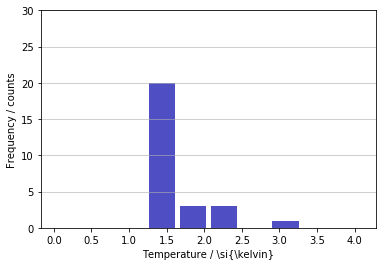

In [9]:
%matplotlib inline
# %matplotlib widget
# data_meas = np.array([])
# for i in quick_data:
#     data_meas = np.append(data_meas, i[i < 1.0])

# print(any(data_meas[data_meas>=1.0]))
# print(len(data_meas))
# mean = np.mean(data_meas)
# std = np.std(data_meas)
# print(mean, std)
x=[1.3, 1.32, 1.33, 1.34, 1.36, 1.37, 1.38, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7, 1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8, 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 2.01, 2.02, 2.03, 2.05, 2.06, 2.08, 2.09, 2.12, 2.13, 2.17, 2.2, 2.21, 2.29, 2.3, 2.33, 2.36, 2.37, 2.39, 2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5, 2.51, 2.52, 2.53, 2.55, 2.56, 2.57, 2.61, 2.79, 2.87, 2.9, 2.91, 2.92, 2.94, 2.96, 2.97]
x=[1.37, 1.41, 1.42, 1.43, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.61, 1.66, 1.69, 1.96, 2.07, 2.11, 2.27, 3.01]

n, bins, patches = plt.hist(x=x, bins=10, range=(0,4.11), color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel(r'Temperature / \si{\kelvin}')
plt.ylabel('Frequency / counts')
#plt.title('My Very Own Histogram')
#plt.text(0.8, 0.8, r'$mean=' + '{:1.3f}'.format(np.round(mean, 3)) + ', std = ' + '{:1.3f}'.format(np.round(std, 3)), ha='right', va='top', transform=ax.transAxes)
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

## Calculate Calibration breakpoints for Cernox bare-chip
The Cernox sensors are calibrated through breakpoint pairs of sensor value and temperature value. The sensor values must be expressed in log(Ohm). Here we take the temperature values of a calibrated sensor and compare them to the sensor values of an uncalibrated bare-chip. 

In [22]:
%gui qt5
default_path = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Calibration data\\Temperature sensors\\Cernox sensors\\self_calibrated'
filename = PureWindowsPath(default_path)
default_path = Path(filename)
filename = QFileDialog.getOpenFileName(None, 'Import file', str(default_path),"Text files (*.csv *.dat *.txt)")
print(filename[0])
file_import = Path(filename[0])
#quick_data = np.loadtxt(file_import, skiprows=1)
calib_data = pd.read_csv(file_import, sep=r'\t\s*', engine='python', decimal='.')
#print(quick_data)
#quick_data.replace(['nan', 'None', 'NaN'], '', inplace=True)
#calib_data = calib_data.apply(pd.to_numeric)
print('Select from these columns: ', list(calib_data)) # prints column names to be used in cell 'Plot'

//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Calibration data/Temperature sensors/Cernox sensors/self_calibrated/calib_barechip_raw_data.txt
Select from these columns:  ['T [K]', 'R [Ohm]']


In [29]:
#print(calib_data)
Temperature_values = calib_data['T [K]']
sensor_R_values = np.log10(calib_data['R [Ohm]'])
#print(Temperature_values, sensor_R_values)

T_list = [float(Temperature_values[0])]
R_list = [sensor_R_values[0]]
print(np.max(sensor_R_values))
print(np.min(sensor_R_values))
value_spacing = (np.max(sensor_R_values)-np.min(sensor_R_values))/200

r_bef = sensor_R_values[0]
#print(r_bef)
i=0
for t,r in zip(Temperature_values, sensor_R_values):
    if (r_bef - r >= value_spacing) and r <= np.max(sensor_R_values):
        T_list.append(float(t))
        R_list.append(r)
        r_bef=r
    else: i+=1
        
print(i)
    
print("Value spacing: ", value_spacing)
# plt.plot(Temperature_values, sensor_R_values)
#print(T_list, R_list)
print(len(T_list), len(R_list))

path_calib = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Calibration data\\Temperature sensors\\Cernox sensors\\self_calibrated\\Calibration_X000001.txt'
Calib_dict = {'Units': ['%.5f' % round(i,5) for i in R_list[::-1]], 'Temperature (K)': ['%.3f' % round(i,5) for i in T_list[::-1]]} # change Tc, only raw data
df = pd.DataFrame(Calib_dict)
df.to_csv(Path(path_calib), sep=' ')

2.475613084841581
1.4558798371847255
72011
Value spacing:  0.005098666238284278
191 191


### Plot calibration curves from xls file

In [22]:
%gui qt5
default_path = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_measured\\Cernox sensor calibration\\'
filename = PureWindowsPath(default_path)
default_path = Path(filename)
filename = QFileDialog.getOpenFileNames(None, 'Import file', str(default_path),"XLS files (*.xlsx *.xls)")
filename = filename[0]
#print(filename)
calib_data2 = []
for i in filename:
    print(i)
    calib_data_buf = pd.read_excel(i, header=3, usecols=(0,1,2))
#     calib_data2.replace(['nan', 'None', 'NaN'], '', inplace=True)
#     calib_data2 = data.apply(pd.to_numeric)
    calib_data2.append(calib_data_buf)
    print('Select from these columns: ', list(calib_data_buf)) # prints column names to be used in cell 'Plot'

//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/Data_measured/Cernox sensor calibration/constant_warmup_0Vheat_1.4K_to_RT.xls
Select from these columns:  ['Time', 'Input A', 'Input B']
//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/Data_measured/Cernox sensor calibration/constant_warmup_0Vheat_4.15K_to_20K_first_test.xls
Select from these columns:  ['Time', 'Input A', 'Input B']
//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/Data_measured/Cernox sensor calibration/warmup_SD+BR_from_LT_constant pumping.xls
Select from these columns:  ['Time', 'Input A', 'Input B']
//file/e24/Projects/FinleyLab/_IQPGroup/_SSPDs/Data/Diffusivity/Data_measured/Cernox sensor calibration/warmup_SD+BR_from_LT_onlyShortHeFlooding.xls
Select from these columns:  ['Time', 'Input A', 'Input B']


In [24]:
%matplotlib widget

fig=plt.figure()
ax=fig.add_subplot(111)

# plot PDF
pdfname = '\\\\file\\e24\\Projects\\FinleyLab\\_IQPGroup\\_SSPDs\\Data\\Diffusivity\\Data_measured\\Cernox sensor calibration\\' \
          '\\plots\\plot_all_4_calib_curves.pdf'
pdf = PdfPages(pdfname)

x_header = 'Time'# 't [s]'#'raw_T' #
y1_header = 'Input A'#'T_sample [K]'#'raw_B' #'TS_diode[K]'#'T_diode [K]'
y1_legend = [r'$\SI{0}{\milli\tesla}$', r'$\SI{0.66}{\milli\tesla}$', r'$\SI{1.17}{\milli\tesla}$', r'$\SI{10.2}{\milli\tesla}$', r'$\SI{100.3}{\milli\tesla}$', r'$\SI{0}{\tesla}$ r1', r'$\SI{0}{\tesla}$ r2', r'$\SI{0}{\tesla}$ r3']

x_label = r'Time / \si{\second}'
y_label =  r'Temperature / \si{\kelvin}'
marker = '-'



j=0
for i in calib_data2:
    if j==70:
        plt.plot(i[[x_header]].to_numpy()-x_offset[3], i[[y2_header]].to_numpy(), marker, label = y1_legend[j])
    else:   
        #plt.plot(i[[x_header]].to_numpy(), i[[y1_header]].to_numpy(), marker, label=y1_legend[j])
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][j]
        #plt.plot(i[[x_header]].to_numpy(), i[[y1_header]].to_numpy(), marker, label = y1_legend[j], color=color)
        x = i[[x_header]].to_numpy()
        y = i[[y1_header]].to_numpy()
        x = x[y<=20]
        y = y[y<=20]
        plt.plot(x, y, marker, color=color, label = j)
    j+=1
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
legend = ax.legend(loc='lower right', handlelength=2.5, labelspacing=0.5, frameon=False, columnspacing=1)
legend.get_frame().set_linewidth(0.0)
#plt.title(title)
plt.xlabel(x_label)
plt.ylabel(y_label)
#plt.xlim(0, )
#plt.ylim(1,20)
# plot widget
# fig.canvas.layout.width = '7in'
# fig.canvas.layout.height= '6in'

#plot PDF
plt.tight_layout()
pdf.savefig(bbox_inches='tight')
pdf.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …